## Set-up

In [78]:
import sys
import os
sys.path.append(os.path.abspath('..')) # for importing from python files not in the same directory

import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px
import pickle

import numpy as np
from tqdm.notebook import trange

sns.set_theme()
colors = sns.color_palette("deep")

from utils import geometric_median, geometric_medoid, month_to_season, plot_components, normalize_curves, functional_norm
from itertools import permutations, product

# HOTFIX Parse IMCEI
import locale
locale.setlocale(locale.LC_ALL, 'it_IT')

'it_IT'

In [79]:
def align_components(H_results, W_results, A, models, ref_idx=0):
    # Align the components
    n_comp, n_eval_points, n_runs = H_results.shape
    ref_H = H_results[..., ref_idx]

    for n in range(1, n_runs):

        best_permutation = list(range(n_comp))
        eval_points = np.arange(0, n_eval_points, int(n_eval_points / 24))
        best_alignment = np.linalg.norm(ref_H - H_results[..., n][range(n_comp), :], 'fro')

        sources_groups = [np.nonzero(A[:, i])[0] for i in range(A.shape[1])]
        valid_permutations = product(*[permutations(a) for a in sources_groups])
        valid_permutations = [[item for subtuple in permutation for item in subtuple] for permutation in valid_permutations]
        for permutation in valid_permutations:
            alignment = np.linalg.norm(ref_H - H_results[..., n][list(permutation)[:n_comp], :], 'fro')

            if alignment < best_alignment:
                best_alignment = alignment
                best_permutation = list(permutation)

        H_results[..., n] = H_results[..., n][best_permutation, :]
        W_results[..., n] = W_results[..., n][:, best_permutation]
        model = models[n]
        model.components_ = model.components_[best_permutation, :]
        models[n] = model

In [80]:
n_components = 5 # Number of components for the matrix factorization
n_runs = 1000
smoothed = False
smooth_param = ''
specific = '_Italy'
alpha = 3e-10
beta = 1

train_years = ['2021', '2022']
seasons = ['Spring', 'Fall', 'Winter', 'Summer']

colormap = ListedColormap([colors[k] for k in range(n_components)])

daytype_order = [
    'Monday',
    'Working day',
    'Saturday',
    'Holiday'
]

# Process data

## Data matrix $X$

In [81]:
infile = f'../data/2_processed/daily_curves{specific}{smoothed * smooth_param}.csv'
input_df = pd.read_csv(infile, index_col=0)
print(len(input_df))
input_df.head(3)

2191


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2018-01-01_Holiday,24743.000,23797.000,22175.999,21042.000,20146.999,20079.000,20942.001,21712.000,21969.999,22967.000,...,26643.000,26807.000,29947.001,31103.000,31537.000,30804.001,29621.000,27749.000,25388.000,22714.001
Italy_2018-01-02_Working day,22714.001,20794.001,19802.002,19573.002,19679.000,20891.000,24197.999,28537.000,32988.000,37794.999,...,36511.999,37393.000,41395.000,42362.001,42081.001,39555.000,37163.000,33313.000,29811.000,26314.001
Italy_2018-01-03_Working day,26314.001,24248.999,22927.999,22537.999,22314.001,23529.001,27206.000,32970.999,37419.000,40908.999,...,40106.999,40662.001,44557.000,44708.000,43818.999,41347.000,38572.999,34229.001,30436.999,27199.000


In [82]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
unit_info['season'] = unit_info.month.astype(int).map(month_to_season)
df = pd.concat([input_df, unit_info], axis=1)
df = df[df.year.isin(train_years)]
df = df[df.season.isin(seasons)]
print(len(df))
df.head(3)

730


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,region,year,month,daytype,season
Italy_2021-01-01_Holiday,24375.000,23142.999,21418.001,20136.000,19257.999,19473.999,20382.000,21137.000,21204.001,22809.999,...,30031.000,28681.0,27158.999,24913.000,22807.000,Italy,2021,01,Holiday,Winter
Italy_2021-01-02_Saturday,22807.000,21146.000,20085.000,19431.001,19543.000,20095.000,22104.000,23960.001,25809.999,28031.999,...,34347.000,31864.0,29392.999,26308.999,23326.001,Italy,2021,01,Saturday,Winter
Italy_2021-01-03_Holiday,23326.001,21322.000,20397.999,19543.001,19229.000,19879.000,21032.999,22168.000,23240.000,25000.999,...,32547.001,30280.0,28256.999,25917.000,23235.001,Italy,2021,01,Holiday,Winter


In [83]:
X = df.drop(unit_info.columns, axis=1)
X = normalize_curves(X)
p = len(X.columns)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2021-01-01_Holiday,0.040804,0.038742,0.035854,0.033708,0.032238,0.032600,0.034120,0.035383,0.035496,0.038184,...,0.042573,0.043251,0.047590,0.048918,0.050168,0.050272,0.048012,0.045464,0.041705,0.038179
Italy_2021-01-02_Saturday,0.034414,0.031907,0.030306,0.029319,0.029488,0.030321,0.033353,0.036153,0.038945,0.042298,...,0.044727,0.045919,0.050289,0.052199,0.053566,0.051826,0.048080,0.044351,0.039698,0.035197
Italy_2021-01-03_Holiday,0.037353,0.034144,0.032665,0.031295,0.030793,0.031833,0.033681,0.035499,0.037216,0.040036,...,0.043765,0.044670,0.049144,0.051261,0.052497,0.052119,0.048489,0.045250,0.041502,0.037208
Italy_2021-01-04_Monday,0.029707,0.027360,0.026213,0.026345,0.026738,0.027907,0.031743,0.037142,0.042662,0.047633,...,0.049228,0.049020,0.052170,0.052683,0.052748,0.049429,0.045780,0.041584,0.037839,0.033934
Italy_2021-01-05_Working day,0.032900,0.030340,0.028683,0.028162,0.028115,0.029145,0.032760,0.038128,0.043562,0.047061,...,0.048094,0.048353,0.051152,0.051067,0.050467,0.048227,0.044795,0.041040,0.036631,0.032362


## NMF

In [84]:
# Load the arrays from the .npz file
name = ''
arrays_path = f"../data/3_output/pennmf_results/batch/{n_components}comp{smoothed * smooth_param}_alpha_{alpha}_beta_{beta}_{'_'.join(train_years)}_{n_runs}runs{name}.npz"
estimator_path = arrays_path.replace('.npz', '.pkl')
data = np.load(arrays_path)
with open(estimator_path, 'rb') as file:
    estimators = pickle.load(file)
print('Loaded ', arrays_path)
print('Loaded ', estimator_path)

Loaded  ../data/3_output/pennmf_results/batch/5comp_alpha_3e-10_beta_1_2021_2022_1000runs.npz
Loaded  ../data/3_output/pennmf_results/batch/5comp_alpha_3e-10_beta_1_2021_2022_1000runs.pkl


In [85]:
# Access the arrays
C_results = data['C_results']
S_results = data['S_results']
iterations = data['iterations']
loss_nmf = data['loss_nmf']
loss_constraint_c = data['loss_constraint_c']
loss_constraint_s = data['loss_constraint_s']

In [86]:
pd.Series(iterations).quantile(np.linspace(0,1,11))

0.0    1140.0
0.1    1510.0
0.2    1590.0
0.3    1670.0
0.4    1760.0
0.5    1850.0
0.6    1954.0
0.7    2140.0
0.8    2530.0
0.9    3241.0
1.0    5800.0
dtype: float64

In [87]:
# Remove results for which we have less than 100 iterations (they correspond to a local minima where all profile are the same)
S_results = S_results[..., iterations > 100]
C_results = C_results[..., iterations > 100]
estimators = [estimator for estimator, select in zip(estimators, iterations > 100) if select]
loss_nmf = loss_nmf[iterations > 100]
loss_constraint_c = loss_constraint_c[iterations > 100]
loss_constraint_s = loss_constraint_s[iterations > 100]
iterations = iterations[iterations > 100]
print('{} results clean'.format(C_results.shape[2]))

1000 results clean


In [88]:
# Align solutions to have comp x of solution i matching comp x of solution j
A = np.array([
    [1, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1]
])

# A = np.array([
#     [1, 0, 0],
#     [0, 1, 0],
#     [0, 0, 1],
# ])


align_components(S_results, C_results, A, estimators, ref_idx=0)

In [89]:
n_clean_runs = C_results.shape[2]
abscissa = [float(x) for x in X.columns]

<Axes: >

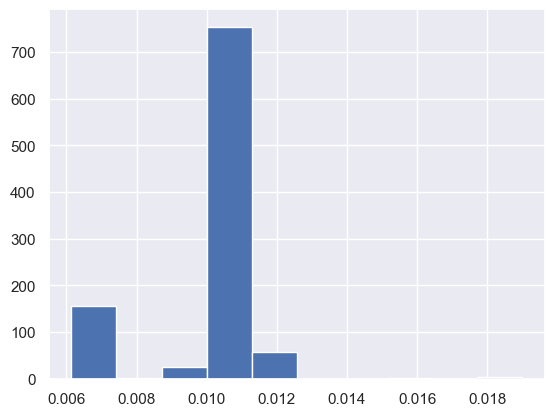

In [90]:
pd.Series(loss_nmf).hist()

In [91]:
# HOTFIX: Remove results for which the NMF loss is in the high group
# threshold = 0.015
threshold = 0.008

S_results = S_results[..., loss_nmf < threshold]
C_results = C_results[..., loss_nmf < threshold]
iterations = iterations[loss_nmf < threshold]
loss_constraint_c = loss_constraint_c[loss_nmf < threshold]
loss_constraint_s = loss_constraint_s[loss_nmf < threshold]
estimators = [estimator for estimator, select in zip(estimators, loss_nmf < threshold) if select]
loss_nmf = loss_nmf[loss_nmf < threshold]
n_clean_runs = C_results.shape[2]
print('{} results clean'.format(n_clean_runs))

159 results clean


## Quick data check

Check-plots on the solutions found

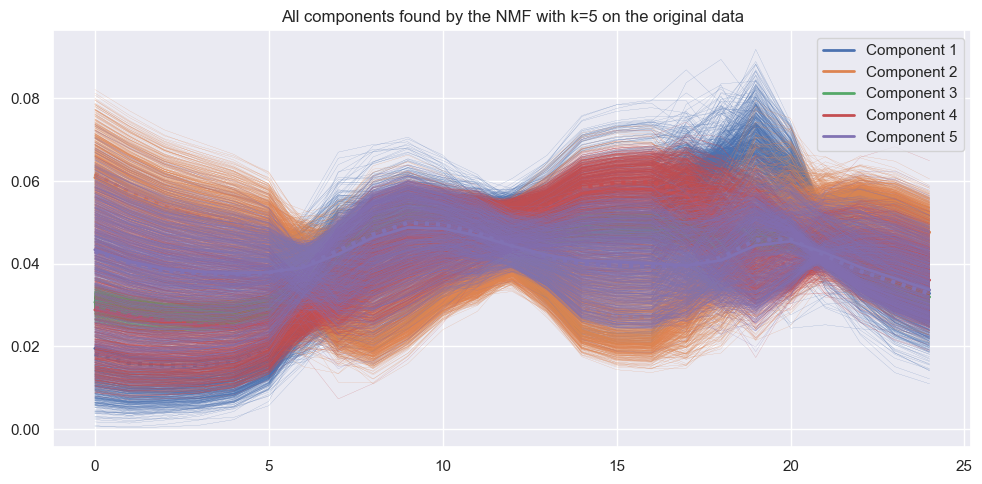

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))

for k in range(n_components):
    for i in range(n_clean_runs):
        line, = ax.plot(abscissa, S_results[k, :, i], linewidth=0.1, color=colors[k])
    label = f'Component {k + 1}'
    ax.plot(abscissa, geometric_median(S_results[k, ...].T), linewidth=2, color=colors[k], label=label)
    ax.plot(abscissa, geometric_medoid(S_results[k, ...].T), linewidth=3, linestyle='dotted', color=colors[k])
ax.set_title(f"All components found by the NMF with k={n_components} on the {(1-smoothed)*'original' + smoothed*'smoothed'} data")
ax.legend()
plt.tight_layout()

Let's plot separately per component

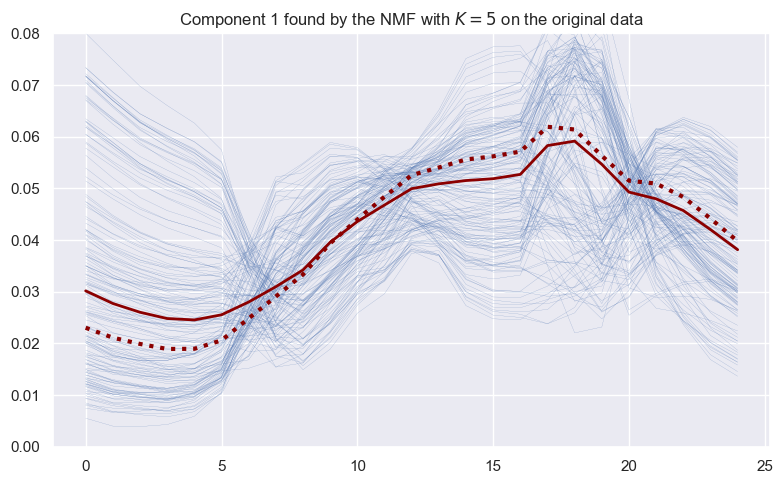

In [92]:
k = 0
fig, ax = plt.subplots(figsize=(8, 5))
for i in range(n_clean_runs):
    line, = ax.plot(abscissa, S_results[k, :, i], linewidth=0.1, color=colors[k])
ax.plot(abscissa, geometric_median(S_results[k, ...].T), linewidth=2, color='darkred')
ax.plot(abscissa, geometric_medoid(S_results[k, ...].T), linewidth=3, linestyle='dotted', color='darkred')
ax.set_title(f"Component {k + 1} found by the NMF with $K={n_components}$ on the {(1-smoothed)*'original' + smoothed*'smoothed'} data")
plt.ylim((0, 0.08))
plt.tight_layout()

<Axes: >

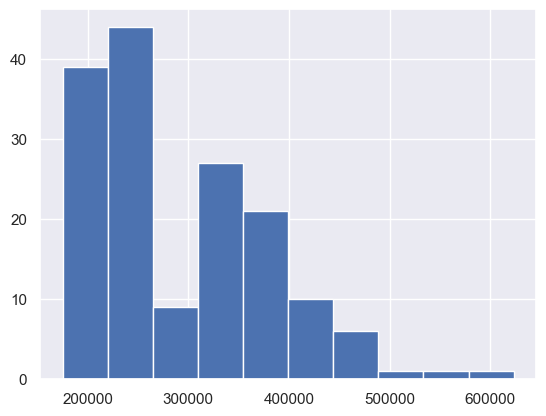

In [93]:
pd.Series(loss_constraint_c).hist()

# Selection of the optimal solution

In [94]:
criteria_df = pd.DataFrame({
    'loss_nmf': loss_nmf,
    'loss_constraint_c': loss_constraint_c,
    'loss_constraint_s': loss_constraint_s,
})
criteria_df

,loss_nmf,loss_constraint_c,loss_constraint_s
0,0.007000,348443.763640,9.287542e-08
1,0.007261,345125.680266,4.240482e-08
2,0.006484,314526.299499,3.580674e-08
3,0.006716,208871.416353,4.222190e-08
4,0.006141,208056.685069,1.274950e-08
...,...,...,...
154,0.006199,227353.780053,2.859170e-08
155,0.006762,219619.538116,4.262649e-08
156,0.006767,238576.955288,1.744510e-08
157,0.006446,236978.446153,2.698744e-08


In [95]:
# Create a scatter plot
fig = px.scatter(
    criteria_df,
    x='loss_nmf',
    y='loss_constraint_c',
    hover_name=criteria_df.index,
    title='Scatter Plot of Loss NMF vs. Loss Constraint on C'
)

# Update layout
fig.update_layout(
    height=500,
    width=500,
    xaxis_title='Loss NMF',
    yaxis_title='Loss Constraint on C'
)

fig.update_traces(selected=dict(marker=dict(color='red')))

# Show plot
fig.show()

In [96]:
# Save all clean solutions
outfile_arrays = f"../data/3_output/pennmf_results/batch_clean/clean_results_{n_components}comp_{n_runs}runs_{'_'.join(train_years)}.npz"
outfile_estimators = outfile_arrays.replace('.npz', '.pkl')

np.savez(outfile_arrays, S_results=S_results, C_results=C_results, iterations=iterations, loss_nmf=loss_nmf, loss_constraint_c=loss_constraint_c, loss_constraint_s=loss_constraint_s)
with open(outfile_estimators, 'wb') as file:
    pickle.dump(estimators, file)

## Optimal solution

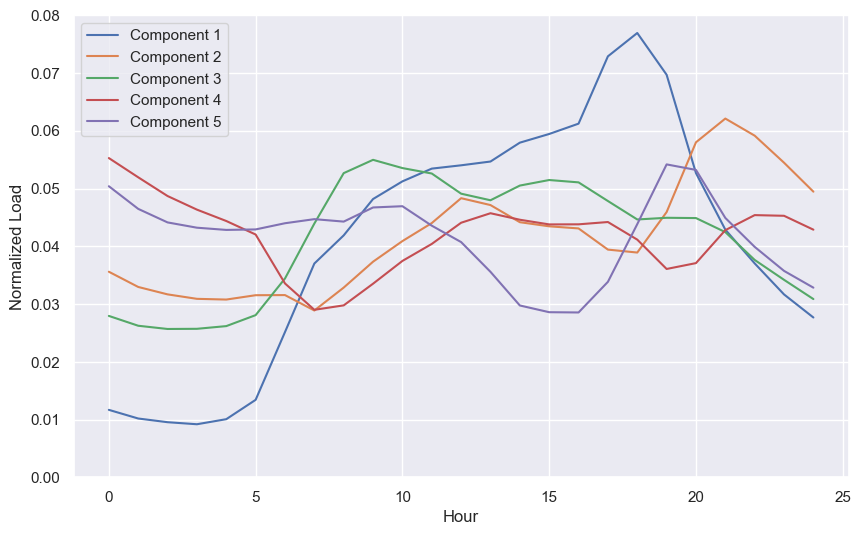

In [98]:
# Other alternative solution
best_run = 147

H = S_results[..., best_run]
C = C_results[..., best_run]
fig, ax = plot_components(H)
ylim = ax.set_ylim((0, 0.08))

# Analysis of the solution

In [99]:
C = pd.DataFrame(C, index=df.index, columns=[f"Component {k+1}" for k in range(n_components)])
C[unit_info.columns] = df[unit_info.columns]
C['season'] = C.month.astype(int).map(month_to_season)
C

,Component 1,Component 2,Component 3,Component 4,Component 5,region,year,month,daytype,season
Italy_2021-01-01_Holiday,0.205651,0.244948,0.014739,0.321698,0.213612,Italy,2021,01,Holiday,Winter
Italy_2021-01-02_Saturday,0.325532,0.233744,0.023759,0.151272,0.264828,Italy,2021,01,Saturday,Winter
Italy_2021-01-03_Holiday,0.268210,0.271332,0.009779,0.210405,0.240341,Italy,2021,01,Holiday,Winter
Italy_2021-01-04_Monday,0.303789,0.149345,0.313102,0.099742,0.133915,Italy,2021,01,Monday,Winter
Italy_2021-01-05_Working day,0.243973,0.077252,0.369621,0.166467,0.142538,Italy,2021,01,Working day,Winter
...,...,...,...,...,...,...,...,...,...,...
Italy_2022-12-27_Working day,0.258707,0.130968,0.348214,0.077128,0.184867,Italy,2022,12,Working day,Fall
Italy_2022-12-28_Working day,0.252674,0.104683,0.346026,0.083054,0.213973,Italy,2022,12,Working day,Fall
Italy_2022-12-29_Working day,0.240378,0.080238,0.320466,0.109843,0.248977,Italy,2022,12,Working day,Fall
Italy_2022-12-30_Working day,0.238647,0.118611,0.285540,0.107514,0.250703,Italy,2022,12,Working day,Fall


In [100]:
C.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration')

,region,year,month,daytype,season,component,concentration
0,Italy,2021,01,Holiday,Winter,Component 1,0.205651
1,Italy,2021,01,Saturday,Winter,Component 1,0.325532
2,Italy,2021,01,Holiday,Winter,Component 1,0.268210
3,Italy,2021,01,Monday,Winter,Component 1,0.303789
4,Italy,2021,01,Working day,Winter,Component 1,0.243973
...,...,...,...,...,...,...,...
3645,Italy,2022,12,Working day,Fall,Component 5,0.184867
3646,Italy,2022,12,Working day,Fall,Component 5,0.213973
3647,Italy,2022,12,Working day,Fall,Component 5,0.248977
3648,Italy,2022,12,Working day,Fall,Component 5,0.250703


<Axes: xlabel='component', ylabel='concentration'>

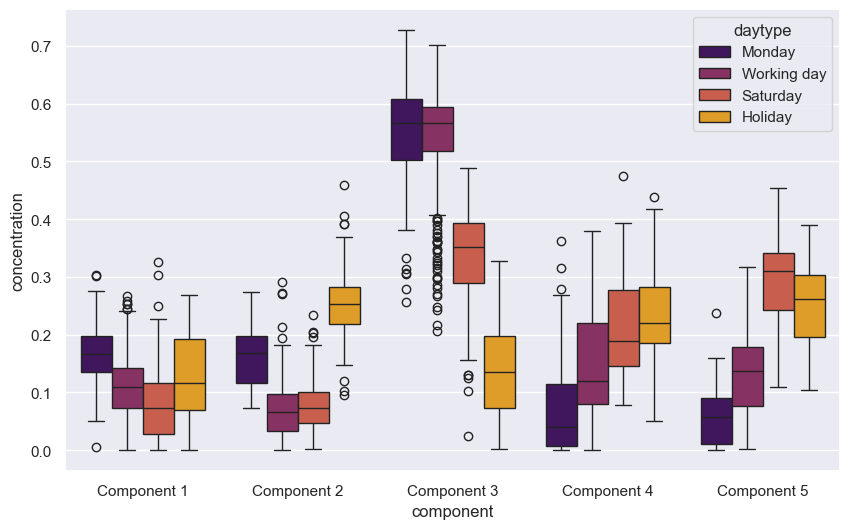

In [101]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=C.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='component',
    y='concentration',
    hue='daytype',
    hue_order=daytype_order,
    palette='inferno'
)

<Axes: xlabel='month', ylabel='concentration'>

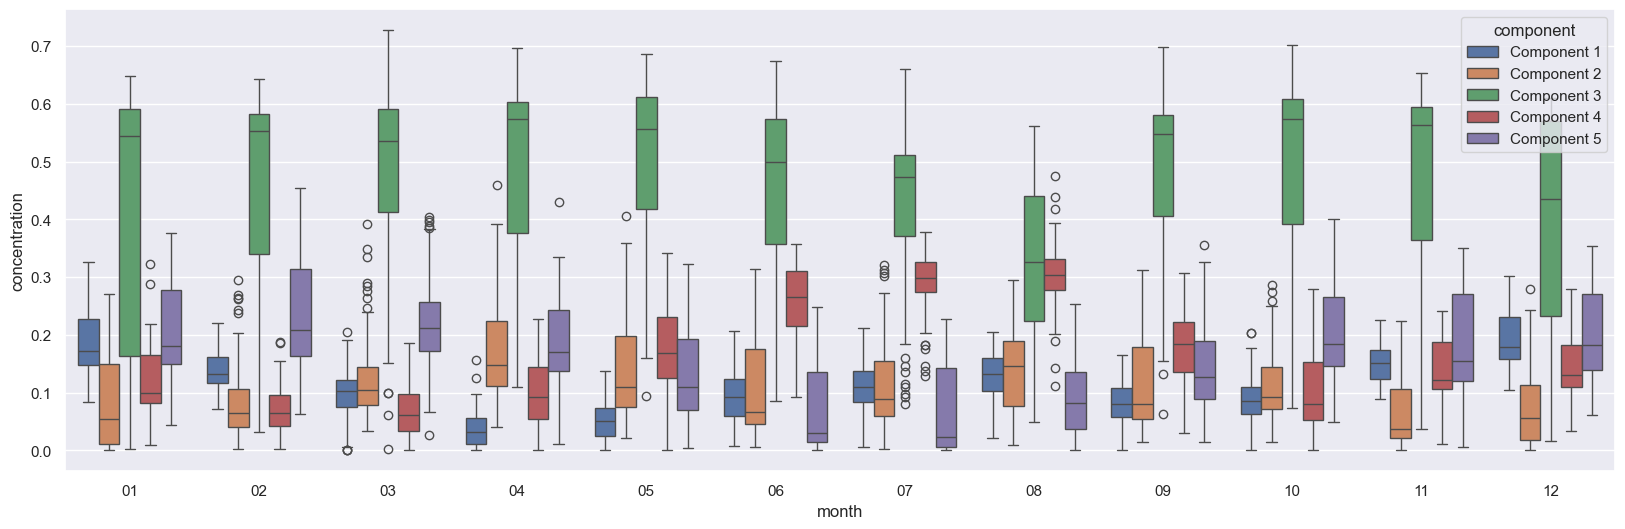

In [102]:
plt.figure(figsize=(20,6))
sns.boxplot(
    data=C.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
)

<Axes: xlabel='month', ylabel='concentration'>

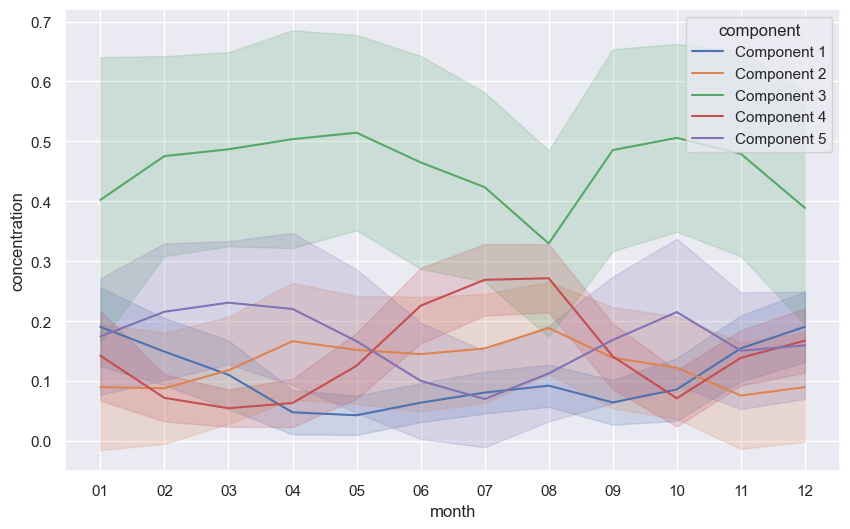

In [65]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=C.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
    errorbar='sd'
)

In [66]:
dimensions = [f'Component {k+1}' for k in range(n_components)]
height, width = 1000, 1100

fig = px.scatter_matrix(C, dimensions=dimensions, hover_name=C.index, color='daytype')
fig.update_layout(height=height, width=width)
fig.update_traces(selected=dict(marker=dict(color='yellow')))
fig.show()

## Save results

In [39]:
opt = ''
specific = '_Italy_lambda_3e-10'
outfile_arrays = f"data/3_output/nmf_results/WHopt{opt}_{n_components}comp{'_smoothed'*smoothed}_{n_runs}runs_{name}.npz"
np.savez(outfile_arrays, W=C, H=H)
outfile_estimator = f"data/3_output/nmf_results/PenNMF_{n_components}comp{'_smoothed'*smoothed}_{n_runs}runs_{name}.pkl"
with open(outfile_estimator, 'wb') as file:
    pickle.dump(estimators[best_run], file)
print("Saved arrays at", outfile_arrays)
print("Saved estimator at", outfile_estimator)

Saved arrays at data/3_output/nmf_results/WHopt_5comp_1000runs_PenNMF_lambda_3e-10.npz
Saved estimator at data/3_output/nmf_results/PenNMF_5comp_1000runs_PenNMF_lambda_3e-10.pkl


___

# TESTS